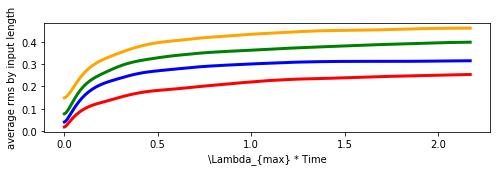

In [34]:
DMD_2bit = np.load('DMD_Nres_1000_2bit/DMD_Nres_1000_2bit.npy')
DMD_4bit = np.load('DMD_Nres_1000_4bit/DMD_Nres_1000_4bit.npy')
DMD_6bit = np.load('DMD_Nres_1000_6bit/DMD_Nres_1000_6bit.npy')
DMD_8bit = np.load('DMD_Nres_1000_8bit/DMD_Nres_1000_8bit.npy')

plt.figure(1,figsize=(8,2))
plt.ylabel('average rms by input length')
plt.xlabel('\Lambda_{max} * Time')
plt.plot(tt[:DMD_2bit.shape[0]]*lyap_exp_max, DMD_2bit, color='orange', linewidth=3.0)
plt.plot(tt[:DMD_4bit.shape[0]]*lyap_exp_max, DMD_4bit, color='green', linewidth=3.0)
plt.plot(tt[:DMD_6bit.shape[0]]*lyap_exp_max, DMD_6bit, color='blue', linewidth=3.0)
plt.plot(tt[:DMD_8bit.shape[0]]*lyap_exp_max, DMD_8bit, color='red', linewidth=3.0)
plt.savefig('DMD_encoding_depth_dependence.png')
plt.show;

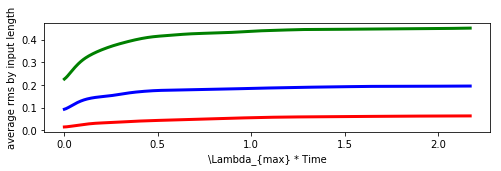

In [33]:
SLM_Nres_10000 = np.load('SLM_Nres_10000/SLM_8bit.npy')
SLM_Nres_1000 = np.load('SLM_Nres_1000/SLM_8bit.npy')
SLM_Nres_100 = np.load('SLM_Nres_100/SLM_8bit.npy')

plt.figure(1,figsize=(8,2))
plt.ylabel('average rms by input length')
plt.xlabel('\Lambda_{max} * Time')
plt.plot(tt[:SLM_Nres_10000.shape[0]]*lyap_exp_max, SLM_Nres_10000, color='red', linewidth=3.0)
plt.plot(tt[:SLM_Nres_1000.shape[0]]*lyap_exp_max, SLM_Nres_1000, color='blue', linewidth=3.0)
plt.plot(tt[:SLM_Nres_100.shape[0]]*lyap_exp_max, SLM_Nres_100, color='green', linewidth=3.0)
plt.savefig('SLM_Nres_dependence.png')
plt.show;

In [1]:
#!/usr/bin/python

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# import os
# import sys
import numpy as np

import time

from reservoir import Reservoir
import data2D
import data_utils
import matlab.engine
eng = matlab.engine.start_matlab()

%load_ext autoreload
%autoreload 2
%aimport data
%aimport reservoir

%matplotlib inline
import matplotlib.pyplot as plt

# setx PATH "%PATH%;C:\Octave\Octave-5.1.0.0

In [2]:
b = Reservoir(n_res=1000, res_encoding=None, 
              input_scale=2, input_encoding='phase', 
              random_projection='simulation', weights_type='complex gaussian', 
              activation_fun='phase', 
              parallel_runs=None, 
              future_pred=True, pred_horizon=50, rec_pred_steps=1,
              train_method='ridge', train_param=1e0, is_complex=True)

In [3]:
# calculate training data
n_sequence=1
spatial_points = 20
ks_data, xx_, tt_ = data2D.kuramoto_sivashinsky(sequence_length=2000, n_sequence=n_sequence, 
                                              spatial_points=spatial_points)
tt = np.linspace(np.amin(tt_), np.amax(tt_), tt_.shape[2])
xx = xx_[0,:,0]
lyap_exp = data2D.kuramoto_sivashinsky_lyap_exp(sequence_length=100, n_sequence = 100, spatial_points=20)

# plot training data
# fig, axs = plt.subplots(n_sequence, 1, sharex=True, figsize=(9,9))
# plt.suptitle('Training data: solution u(x,t) of Kuramoto-Sivashinsky equation, system size L = 22             ')
# plt.ylabel('x')
# plt.xlabel('\Lambda_{max} * Time')
# for i in range(n_sequence):
#     im=axs[i].pcolormesh(tt*lyap_exp, xx, ks_data[i, :,:].T, cmap='viridis')
# fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.4)

In [5]:
# Algorithm training
b.fit(ks_data)

Start of training...
Initialization finished. Elapsed time: 0.10771918296813965s
100%|██████████| 2001/2001 [00:01<00:00, 1343.23it/s]
Iterations finished. Elapsed time: 1.497258186340332s
Training finished. Elapsed time: 23.80468201637268s
Training score: 0.9998585301543095


Reservoir(activation_fun='phase', activation_param=None, forget=100,
     future_pred=True, input_enc_dim=1, input_enc_param=3.141592653589793,
     input_encoding='phase', input_scale=2, is_complex=True, n_res=1000,
     parallel_runs=None, pred_horizon=50, random_projection='simulation',
     random_state=<mtrand.RandomState object at 0x7feaa405db88>,
     rec_pred_steps=1, res_enc_dim=1, res_enc_param=None,
     res_encoding=None, res_scale=1, save=0, train_method='ridge',
     train_param=1.0, verbose=1, weights_type='complex gaussian')

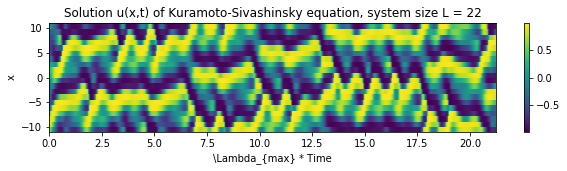

In [6]:
# calculate testing data
ks_data, _, _ = data2D.kuramoto_sivashinsky(sequence_length=2000, n_sequence=1, spatial_points=spatial_points)

# plot testing data
plt.figure(1,figsize=(10,2))
plt.title('Solution u(x,t) of Kuramoto-Sivashinsky equation, system size L = 22')
plt.ylabel('x')
plt.xlabel('\Lambda_{max} * Time')
im=plt.pcolormesh(tt*lyap_exp, xx, ks_data[0, :,:].T, cmap='viridis')
plt.colorbar(im)

In [7]:
# Algorithm testing
pred_output, valid_score = b.score(ks_data)

Start of testing...
Initialization finished. Elapsed time: 0.0040547847747802734
100%|██████████| 2001/2001 [00:01<00:00, 1328.51it/s]
Iterations finished. Elapsed time: 1.513857364654541
Testing finished. Elapsed time: 23.196645736694336
Testing score: 0.30461382284986294


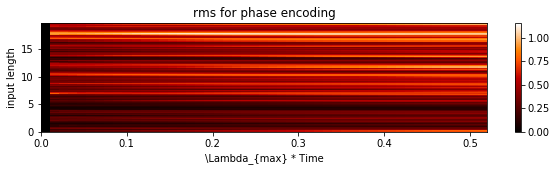

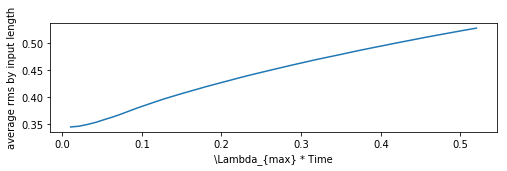

In [8]:
# prediction RMSE
steps_in_total_pred = b.pred_horizon*b.rec_pred_steps
y_target = data_utils.roll_and_concat(ks_data[:,b.forget:,:], roll_num=b.pred_horizon)[0]
length_input = pred_output.shape[0] - steps_in_total_pred
rms = np.zeros((length_input, steps_in_total_pred))
for n_input in range(1, length_input):
    for n_pred in range(1, steps_in_total_pred):
        d1 = pred_output[n_input, :].reshape(-1, spatial_points+1)[0:n_pred,:]
        d2 = y_target[n_input:n_input+n_pred, 0:spatial_points+1]
        
        rms[n_input, n_pred] = np.sqrt(1./(n_pred*(spatial_points+1))*np.sum((d1.flatten() - d2.flatten())**2))


time_input = tt[0:n_input+1]*lyap_exp
time_pred = tt[0:steps_in_total_pred]*lyap_exp

plt.figure(1,figsize=(10,2))
plt.title('rms for phase encoding')
plt.ylabel('input length')
plt.xlabel('\Lambda_{max} * Time')
im=plt.pcolormesh(time_pred, time_input, rms[:,:], cmap='gist_heat')
plt.colorbar(im)
plt.show;

plt.figure(2,figsize=(8,2))
plt.ylabel('average rms by input length')
plt.xlabel('\Lambda_{max} * Time')
plt.plot(time_pred[1:], np.sum(rms[:,1:], axis=0)/length_input)
plt.show;
# np.save('SLM_timesteps_20000.npy', np.sum(rms[:,1:], axis=0)/length_input)

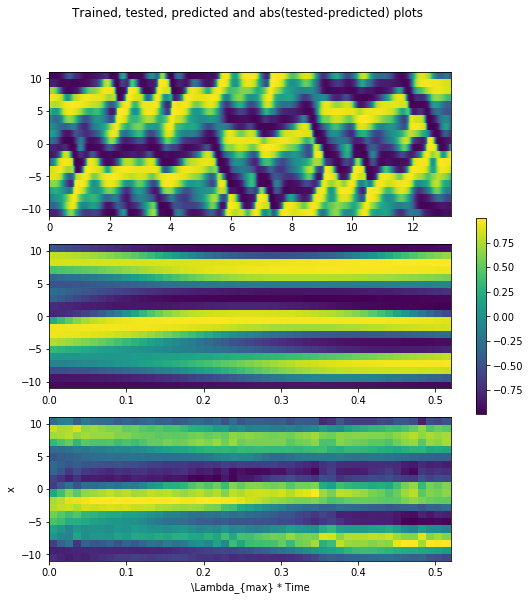

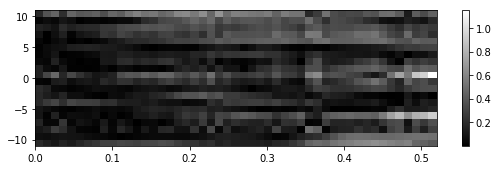

In [13]:
n_input = 1250 #round(pred_output.shape[0]/2-300)

input_data = y_target[0:n_input, 0:spatial_points+1]

prediction = np.zeros((steps_in_total_pred, spatial_points + 1))
for i in range(steps_in_total_pred):
    prediction[i, :] = pred_output[n_input, i*(spatial_points+1):(i+1)*(spatial_points + 1)]
    
targetted_data = y_target[n_input:n_input+steps_in_total_pred, 0:spatial_points+1]

# time = tt[0:n_input+steps_in_total_pred]*lyap_exp
vmax = max(abs(np.concatenate((targetted_data,input_data)).flatten()))
vmin = -vmax

# plot training data
fig, axs = plt.subplots(3, 1, sharex=False, figsize=(9,9))
plt.suptitle('Trained, tested, predicted and abs(tested-predicted) plots                       ')
plt.ylabel('x')
plt.xlabel('\Lambda_{max} * Time')
datum = [input_data, targetted_data, prediction, np.abs(targetted_data-prediction)]
for i in range(3):
    time = (tt[0:n_input] if i==0 else tt[0:steps_in_total_pred])*lyap_exp
    im=axs[i].pcolormesh(time, xx, datum[i].T, cmap='viridis', vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.4)

plt.figure(3,figsize=(9,2.5))
im=plt.pcolormesh(time, xx, datum[3].T, cmap='gray')
plt.colorbar(im)
# # plt.savefig('DND_input_data.png')

<function matplotlib.pyplot.show(*args, **kw)>

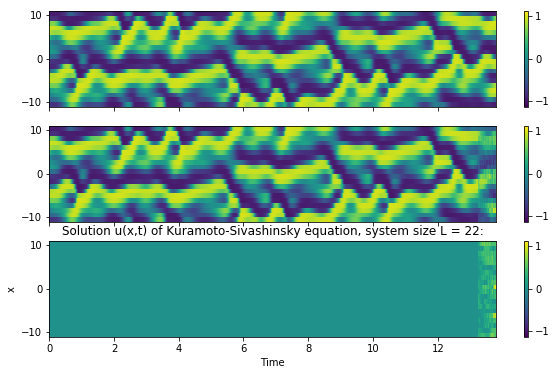

In [14]:
n_input = 1250 #round(pred_output.shape[0]/2-300)
prediction = np.zeros((steps_in_total_pred, spatial_points + 1))
for i in range(steps_in_total_pred):
    prediction[i, :] = pred_output[n_input, i*(spatial_points+1):(i+1)*(spatial_points + 1)]
all_data = np.concatenate((y_target[0:n_input, 0:spatial_points+1], prediction*(1/np.amax(prediction))))

fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10,6))
data_1 = y_target[0:n_input+steps_in_total_pred, 0:spatial_points+1].T
data_2 = all_data.T
data_3 = y_target[0:n_input+steps_in_total_pred, 0:spatial_points+1].T-all_data.T
time = tt[0:n_input+steps_in_total_pred]*lyap_exp
vmax = max(abs(np.concatenate((data_1,data_2,data_3)).flatten()))
vmin = -vmax
plt.title('Solution u(x,t) of Kuramoto-Sivashinsky equation, system size L = 22:')
plt.ylabel('x')
plt.xlabel('Time')
im=axs[0].pcolormesh(time, xx, y_target[0:n_input+steps_in_total_pred, 0:spatial_points+1].T, cmap='viridis', vmin=vmin, vmax=vmax)
plt.colorbar(im, ax=axs[0])

im=axs[1].pcolormesh(time, xx, all_data.T, cmap='viridis', vmin=vmin, vmax=vmax)
plt.colorbar(im, ax=axs[1])

im=axs[2].pcolormesh(time, xx, np.abs(y_target[0:n_input+steps_in_total_pred, 0:spatial_points+1].T-all_data.T), cmap='viridis', vmin=vmin, vmax=vmax)
plt.colorbar(im, ax=axs[2])
plt.show